# Importing packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader

os.system('pip install facenet-pytorch')
from facenet_pytorch import MTCNN

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer

os.system('pip install pycm')
os.system('pip install -U nltk')
os.system('python -m nltk.downloader all')
os.system('pip install transformers')

import pycm
from nltk.tokenize import word_tokenize
from torchtext.vocab import GloVe
from transformers import AutoTokenizer
from transformers import AutoModel

os.system('git clone https://github.com/AlirezaFT78/DL_lib.git')
from DL_lib.Classes import MSCTDDataset, CNN1, MyModel, NNtfid, NNglove, BertClassifier, faceDataset

# Reading data

In [ ]:
train_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'train', resize = (640,316))
val_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'dev', resize = (640,316))
test_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'test',  resize = (640,316))



batch_size = 32
train_dataloader =  DataLoader(train_data, batch_size=batch_size)
val_dataloader =  DataLoader(val_data, batch_size=batch_size)
test_dataloader =  DataLoader(test_data, batch_size=batch_size)


Loading Text Files
Loading Train Images
Train Images Count: 20240

Loading Text Files
Loading Validation Images
Dev Images Count: 5063

Loading Text Files
Loading Test Images
Test Images Count: 5067


In [ ]:
train_text = train_data.text
train_sentiment = train_data.sentiment
val_text =val_data.text
val_sentiment = val_data.sentiment
test_text = test_data.text
test_sentiment = test_data.sentiment

In [ ]:
y_train = torch.tensor(train_sentiment)
y_val = torch.tensor(val_sentiment)
y_test = torch.tensor(test_sentiment)

y_train.dtype

torch.int64

# Part1

## Part 1-1

In [ ]:
# Learn vocabulary from training texts and vectorize training texts.
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(train_text)

# Vectorize test texts.
x_val = vectorizer.transform(val_text)
x_test = vectorizer.transform(test_text)
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_val = torch.tensor(scipy.sparse.csr_matrix.todense(x_val)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

x_train.dtype

torch.float32

In [ ]:
global_vectors = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:09<00:00, 42666.16it/s]


### Loading Models

In [ ]:
mtcnn = MTCNN(select_largest=False, post_process=False, device='cuda:0')
best_CNN1_model = torch.load('/content/drive/MyDrive/Project/Phase1/CNN1_model.pth')
best_CNN1_model.linear_relu_stack = nn.Sequential(*[best_CNN1_model.linear_relu_stack[i] for i in range(11)])
best_CNN1_model.eval()

In [ ]:
best_resnet_model = torch.load('/content/drive/MyDrive/Project/Phase1/Resnet50_model2.pth')
best_resnet_model[1].linear_relu_stack = nn.Sequential(*[best_resnet_model[1].linear_relu_stack[i] for i in range(8)])
best_resnet_model.eval()

In [ ]:
best_model_tfidf = torch.load('/content/drive/MyDrive/Project/Phase2/NNtfid_model.pth')
best_model_tfidf.linear_relu_stack = nn.Sequential(*[best_model_tfidf.linear_relu_stack[i] for i in range(1)])
best_model_tfidf.eval()

In [ ]:
best_model_glove = torch.load('/content/drive/MyDrive/Project/Phase2/Glove_model.pth')
best_model_glove.linear_relu_stack = nn.Sequential(*[best_model_glove.linear_relu_stack[i] for i in range(9)])
best_model_glove.eval()

In [ ]:
bert_model = "google/bert_uncased_L-12_H-768_A-12" #"google/bert_uncased_L-2_H-128_A-2" "google/bert_uncased_L-4_H-512_A-8" 
tokenizer = AutoTokenizer.from_pretrained(bert_model)
best_model_bert = torch.load('/content/drive/MyDrive/Project/Phase2/Bert_model.pth')
best_model_bert.linear_relu_stack = nn.Sequential(*[best_model_bert.linear_relu_stack[i] for i in range(0)])
best_model_bert.eval()

### New Merge Function

In [ ]:
def final_merge_model(data_loader, best_CNN1_model, best_resnet_model , Face_model,best_model_tfidf,best_model_glove,best_model_bert,vectorizer,global_vectors,tokenizer ):
    i = 0
    acu = 0
    size = len(data_loader.dataset)
    feature_vec = np.zeros((size,849))
    trans = transforms.ToTensor()
    pred_feature =[]
    count = 0
    for batch in tqdm(data_loader):
        y_pred = []
        images = batch['image'].numpy()
        sentiments = batch['sentiment']
        text = batch['text']

        x_samp = vectorizer.transform(text)
        x_samp = torch.tensor(scipy.sparse.csr_matrix.todense(x_samp)).float()
        
        max_words = 25
        embeded_len = 50
        X_tensor_samp = torch.zeros(len(text), max_words*embeded_len )
        for i,line in enumerate(text):
            words = word_tokenize(line)
            words = [word for word in words if word.isalpha()]
            words = words + [""] * (max_words-len(words))
            tensor = global_vectors.get_vecs_by_tokens(words)
            X_tensor_samp[i] = (tensor.reshape(1, -1))



        X3 = batch['image']
        img_snt = zip(images,text,sentiments,X3,x_samp,X_tensor_samp) 

        for img,txt,snt,X3,tfidf,glove in img_snt:
            output =[]
            pred_tfidf = best_model_tfidf(tfidf.to(device))
            pred_glove = best_model_glove(glove.reshape(1,1250).to(device))

            test_encodings = tokenizer(txt, truncation=True, padding=True, max_length=32)
            test_set = {key: torch.tensor(val[:]) for key, val in test_encodings.items()}
            mask = test_set['attention_mask'].to(device)
            mask = mask.reshape(1,mask.shape[0])


            input_id = test_set['input_ids'].to(device)
            input_id = input_id.reshape(1,input_id.shape[0])

            #output.append(best_model_bert(input_id, mask).cpu().item())
            pred_bert = best_model_bert(input_id, mask)

            pred_face = torch.zeros(1, 8).to(device)

            face_img = []
            final_labels = []
            boxes, probs = Face_model.detect(img,landmarks=False)
            try:
                boxes = np.array(boxes,dtype='uint64')
                for x1,y1,x2,y2 in boxes:
                    face = img[y1:y2, x1:x2, :]
                    face = cv2.resize(face,(40,60))
                    X2 = trans(face).to(device)
                    x,y,z = X2.shape
                    X2 = X2.resize(1,x,y,z)
                    pred_face += best_CNN1_model(X2)
            except:
                    X3 = trans(X3.numpy()).to(device)
                    x,y,z = X3.shape
                    X3 = X3.resize(1,x,y,z)
                    pred_face = best_resnet_model(X3)
            pred_face1 = pred_face.detach().cpu().numpy()
            pred_tfidf1 = pred_tfidf.detach().reshape(1,64).cpu().numpy()
            pred_glove1 = pred_glove.detach().reshape(1,8).cpu().numpy()
            pred_bert1 = pred_bert.detach().reshape(1,768).cpu().numpy()

            del pred_face,pred_tfidf,pred_glove
            #pred_feature.append(torch.cat((pred_face,pred_tfidf.reshape(1,64),pred_glove.reshape(1,8),snt.reshape(1,1).to(device)), 1))
            #pred_feature.append(torch.cat((pred_face1,pred_tfidf1,pred_glove1,snt.reshape(1,1)), 1))
            #torch.cuda.empty_cache()
            feature_vec[count] = np.concatenate((pred_face1,pred_tfidf1,pred_glove1,pred_bert1,snt.reshape(1,1)), 1)
            count +=1
            #print(feature_vec.cpu().get_device())
        
            #print(snt.reshape(1,1))
       
    return feature_vec




In [ ]:
a = final_merge_model(train_dataloader, best_CNN1_model, best_resnet_model , mtcnn,best_model_tfidf,best_model_glove,best_model_bert,vectorizer,global_vectors,tokenizer )
pred_feature = torch.tensor(a)
#torch.save(pred_feature, '/content/drive/MyDrive/Project/Phase3/pred_feature_train.t')

100%|██████████| 633/633 [25:48<00:00,  2.45s/it]


In [ ]:
a = final_merge_model(val_dataloader, best_CNN1_model, best_resnet_model , mtcnn,best_model_tfidf,best_model_glove,best_model_bert,vectorizer,global_vectors,tokenizer )
pred_feature = torch.tensor(a)
#torch.save(pred_feature, '/content/drive/MyDrive/Project/Phase3/pred_feature_val.t')

100%|██████████| 159/159 [06:45<00:00,  2.55s/it]


In [ ]:
a = final_merge_model(test_dataloader, best_CNN1_model, best_resnet_model , mtcnn,best_model_tfidf,best_model_glove,best_model_bert,vectorizer,global_vectors,tokenizer )
pred_feature = torch.tensor(a)
#torch.save(pred_feature, '/content/drive/MyDrive/Project/Phase3/pred_feature_test.t')

100%|██████████| 159/159 [06:30<00:00,  2.45s/it]


In [ ]:
pred_feature_train = torch.load('/content/drive/MyDrive/Project/Phase3/pred_feature_train.t')
pred_feature_val = torch.load('/content/drive/MyDrive/Project/Phase3/pred_feature_val.t')
pred_feature_test = torch.load('/content/drive/MyDrive/Project/Phase3/pred_feature_test.t')


In [ ]:
x_train = torch.tensor(pred_feature_train[:,:848] ,dtype = (torch.float32))
y_train = torch.tensor(pred_feature_train[:,-1], dtype =(torch.int64))

x_val = torch.tensor(pred_feature_val[:,:848] ,dtype = (torch.float32))
y_val = torch.tensor(pred_feature_val[:,-1], dtype =(torch.int64))

x_test = torch.tensor(pred_feature_test[:,:848] ,dtype = (torch.float32))
y_test = torch.tensor(pred_feature_test[:,-1], dtype =(torch.int64))

<ipython-input-27-4a26820d5331>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(pred_feature_train[:,:848] ,dtype = (torch.float32))
<ipython-input-27-4a26820d5331>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(pred_feature_train[:,-1], dtype =(torch.int64))


In [ ]:
# Defining the Neural Network Layers, Neurons and Activation Function
class MLPClassifier(nn.Module):
    def __init__(self, dim):
        
        self.dim = dim
        super(MLPClassifier, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
                      nn.Dropout(0.5),
                      nn.Linear(self.dim, 512),
                      nn.BatchNorm1d(512),                                     
                      nn.ReLU(),
                      
                      
                      nn.Dropout(0.5),
                      nn.Linear(512, 256),
                      nn.BatchNorm1d(256),                      
                      nn.ReLU(),

                      nn.Dropout(0.5),
                      nn.Linear(256, 64),
                      nn.BatchNorm1d(64),                      
                      nn.ReLU(),

                      nn.Dropout(0.5),
                      nn.Linear(64, 8),
                      nn.BatchNorm1d(8),                      
                      nn.ReLU(),

                      nn.Dropout(0.5),
                      nn.Linear(8, 3),
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
def train_loop(x_train,y_train, model, loss_fn, optimizer):
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    train_loss, correct = 0, 0
    optimizer.zero_grad()

    pred = model.forward(x_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    train_loss = loss.item()
    correct += (pred.argmax(1) == y_train).type(torch.float).sum().item()

    optimizer.step()

    return 100*correct/len(x_train), train_loss

# Defining the function that will do calculation of Loss and Accuracy over Test Dataset
def Accuracy_Loss(x,y, model, loss_fn):
    x_test = x.to(device)
    y_test = y.to(device)
   

    with torch.no_grad():
        pred = model(x_test)
        test_loss = loss_fn(pred, y_test).item()

        y_pred = pred.argmax(1)
        correct = (pred.argmax(1) == y_test).type(torch.float).sum().item()
        
    return 100*correct/len(x_test), test_loss

In [ ]:
learning_rate = 3e-4
batch_size = 128
epochs = 100
loss_fn = nn.CrossEntropyLoss()

# model and optimizer defenintion
model = MLPClassifier(dim = 848).to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0
for e in range(epochs):
    
    print(f'epoch {e+1}/{epochs}:')
    
    model.train()
    t_loss = train_loop(x_train,y_train, model, loss_fn, optimizer)
    train_loss_model.append(t_loss[1]),train_acu_model.append(t_loss[0])

    model.eval()

   
    v_loss =  Accuracy_Loss(x_val,y_val, model, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{t_loss[1]:0.4f}    train acc:{t_loss[0]:0.3f} ---- val loss:{v_loss[1]:0.4f}   val acc:{v_loss[0]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(model, 'model.pth')
        best_epoch = e+1
        
best_model = torch.load('model.pth')
best_model.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Train Set:", train_acu_model[best_epoch-1])  
print("Best Model Accuracy for Validation Set:",val_acu_model[best_epoch-1]) 
print("Best Model Accuracy for Test Set:",Accuracy_Loss(x_test,y_test, best_model, loss_fn)[0])    

torch.save(best_model, '/content/drive/MyDrive/Project/Phase3/MLP_model.pth')

epoch 1/100:
train loss:1.2101    train acc:33.681 ---- val loss:1.1044   val acc:39.917 

epoch 2/100:
train loss:1.1472    train acc:36.966 ---- val loss:1.0991   val acc:37.073 

epoch 3/100:
train loss:1.0864    train acc:41.141 ---- val loss:1.0910   val acc:37.823 

epoch 4/100:
train loss:1.0493    train acc:43.236 ---- val loss:1.0802   val acc:43.176 

epoch 5/100:
train loss:1.0199    train acc:45.746 ---- val loss:1.0660   val acc:52.657 

epoch 6/100:
train loss:1.0030    train acc:47.470 ---- val loss:1.0488   val acc:56.389 

epoch 7/100:
train loss:0.9881    train acc:48.977 ---- val loss:1.0298   val acc:57.950 

epoch 8/100:
train loss:0.9754    train acc:50.316 ---- val loss:1.0104   val acc:59.016 

epoch 9/100:
train loss:0.9586    train acc:51.798 ---- val loss:0.9915   val acc:59.530 

epoch 10/100:
train loss:0.9573    train acc:52.559 ---- val loss:0.9738   val acc:59.826 

epoch 11/100:
train loss:0.9455    train acc:53.340 ---- val loss:0.9583   val acc:60.083

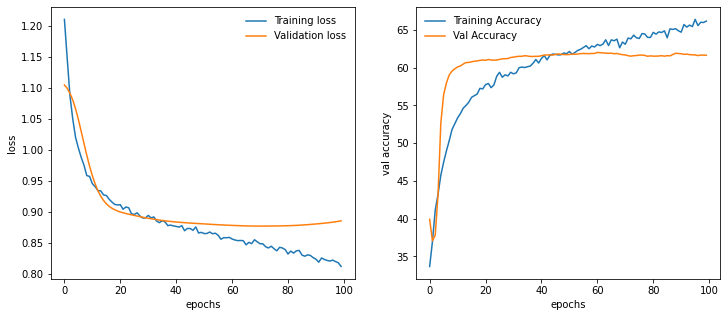

In [ ]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_loss_model, label='Training loss')
plt.plot(val_loss_model, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('val accuracy')
plt.plot(train_acu_model, label='Training Accuracy')
plt.plot(val_acu_model, label='Val Accuracy')
plt.legend(frameon=False);


Overall Statistics : 

ACC Macro                                                         0.7491
F1 Macro                                                          0.61195
FPR Macro                                                         0.18757
Kappa                                                             0.42793
Overall ACC                                                       0.62364
PPV Macro                                                         0.62078
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.61461
Zero-one Loss                                                     1907

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.72193       0.75173       0.77363       
AUC(Area under the ROC curve)                                     0.68479  

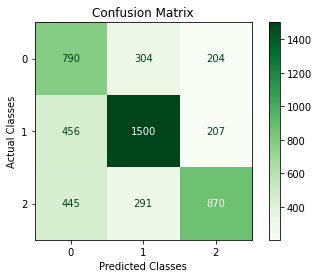

In [ ]:
best_model_multi = torch.load('/content/drive/MyDrive/Project/Phase3/MLP_model.pth')
best_model.eval()
pred = best_model(x_test.to(device))

y_pred = pred.argmax(1).tolist()

y_actu = y_test.tolist()
cm = pycm.ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred)
cm.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")
cm.stat(summary=True)

# Part2

## Loading Models

In [ ]:
mtcnn = MTCNN(select_largest=False, post_process=False, device='cuda:0')
best_CNN1_model = torch.load('/content/drive/MyDrive/Project/Phase1/CNN1_model.pth')

bert_model = "google/bert_uncased_L-12_H-768_A-12" #"google/bert_uncased_L-2_H-128_A-2" "google/bert_uncased_L-4_H-512_A-8" 
tokenizer = AutoTokenizer.from_pretrained(bert_model)
best_model_bert = torch.load('/content/drive/MyDrive/Project/Phase2/Bert_model.pth')

## Setting grad

In [ ]:
# CNN Setting
for p in best_CNN1_model.conv2d_relu_stack.parameters():
  p.requires_grad=False
grad = []
for p in best_CNN1_model.parameters():
  grad.append(p.requires_grad)
print(grad)

# Bert Setting
for p in best_model_bert.parameters():
  p.requires_grad=False

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True]


## Acu Function

In [ ]:
def Accuracy_Loss(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            X,y = batch['image'].to(device), batch['sentiment'].to(device)
            pred = model(X)
            loss += float(loss_fn(pred, y).item())
            y_pred = pred.argmax(1)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    return 100*correct, loss

## Face model

### Testset for Pseudo Labels and Valset for Eval

In [ ]:
learning_rate = 1e-4
batch_size = 128
epochs = 30
loss_fn = nn.CrossEntropyLoss().to(device)

# model and optimizer defenintion
best_CNN1_model = torch.load('/content/drive/MyDrive/Project/Phase1/CNN1_model.pth')
for p in best_CNN1_model.conv2d_relu_stack.parameters():
  p.requires_grad=False

best_CNN1_model.eval()
best_CNN1_model = best_CNN1_model.to(device)
best_model_bert = best_model_bert.to(device)
optimizer = torch.optim.Adam(best_CNN1_model.parameters(), lr=learning_rate)

# test data is like a unsup train dataset and val is for test
test_dataloader =  DataLoader(test_data, batch_size=batch_size)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=32)
face_val = faceDataset(mode = 'val', dir='/content/drive/MyDrive/Project/Phase1', transform = ToTensor())
face_val_dataloader = DataLoader(face_val, batch_size=batch_size, shuffle=True)

# Pre-Train Result
print('Result Before Train :')
print("Model Accuracy for Val Set:", Accuracy_Loss(face_val_dataloader, best_CNN1_model, loss_fn)[0])  

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0
for e in range(epochs):
    # Pre-Train setup
    best_CNN1_model.train()
    num_batches = len(test_dataloader)
    loss_av = 0
    print(f'epoch {e+1}/{epochs}:')

    # Train Loop
    for batch in tqdm(test_dataloader):
        # Pesudo-Labels Extraction
        texts = batch['text']
        tokens = tokenizer(texts, truncation=True, padding=True, max_length=32)
        mask = torch.tensor(tokens['attention_mask']).to(device)
        input_id = torch.tensor(tokens['input_ids']).squeeze(1).to(device)
        peusdo_label = best_model_bert(input_id, mask)
        
        # Face-Batch Extraction
        images = batch['image']
        img_snt = zip(images,peusdo_label) 
        trans = transforms.ToTensor()
        face_batch = []
        y_batch = []
        for img,snt in img_snt:
          face_img = []
          boxes, probs = mtcnn.detect(img,landmarks=False)
          try:
            boxes = np.array(boxes,dtype='uint64')
            for x1,y1,x2,y2 in boxes:
                face = img[y1:y2, x1:x2, :].numpy()
                face = cv2.resize(face,(40,60))
                face_batch.append(trans(face).numpy())
                y_batch.append(snt.cpu().numpy())
          except:
            se = 5
        # Making Tensor Batches
        face_batch = np.array(face_batch)
        X = torch.tensor(face_batch).to(device)
        y_batch = np.array(y_batch)
        y = torch.tensor(y_batch).to(device)

        # Loss over Logits
        pred = best_CNN1_model(X)
        loss = loss_fn(pred, y)
        loss_av += float(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_av /= num_batches
    train_loss_model.append(loss_av)

    # Testing the Improvement with val data
    best_CNN1_model.eval()
    v_loss =  Accuracy_Loss(face_val_dataloader, best_CNN1_model, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{train_loss_model[e]:0.4f}  ---- val loss:{val_loss_model[e]:0.4f}   val acc:{val_acu_model[e]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(best_CNN1_model, 'model.pth')
        best_epoch = e+1
        
best_model = torch.load('model.pth')
best_model.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Test Set:", Accuracy_Loss(face_val_dataloader, best_CNN1_model, loss_fn)[0])    
torch.save(best_model, '/content/drive/MyDrive/Project/Phase3/WS_CNN_model.pth')

Result Before Train :


100%|██████████| 48/48 [00:11<00:00,  4.01it/s]


Model Accuracy for Val Set: 38.204626914304335
epoch 1/30:


100%|██████████| 48/48 [00:02<00:00, 22.10it/s]


train loss:3.4481  ---- val loss:1.0922   val acc:36.168 

epoch 2/30:


100%|██████████| 48/48 [00:02<00:00, 22.17it/s]


train loss:3.4371  ---- val loss:1.0925   val acc:35.761 

epoch 3/30:


100%|██████████| 48/48 [00:02<00:00, 18.83it/s]


train loss:3.4346  ---- val loss:1.0928   val acc:35.549 

epoch 4/30:


100%|██████████| 48/48 [00:02<00:00, 18.07it/s]


train loss:3.4329  ---- val loss:1.0929   val acc:35.516 

epoch 5/30:


100%|██████████| 48/48 [00:02<00:00, 22.55it/s]


train loss:3.4316  ---- val loss:1.0930   val acc:35.402 

epoch 6/30:


100%|██████████| 48/48 [00:02<00:00, 22.38it/s]


train loss:3.4303  ---- val loss:1.0933   val acc:35.435 

epoch 7/30:


100%|██████████| 48/48 [00:02<00:00, 20.44it/s]


train loss:3.4290  ---- val loss:1.0935   val acc:35.435 

epoch 8/30:


100%|██████████| 48/48 [00:02<00:00, 18.23it/s]


train loss:3.4276  ---- val loss:1.0936   val acc:35.500 

epoch 9/30:


100%|██████████| 48/48 [00:02<00:00, 22.31it/s]


train loss:3.4261  ---- val loss:1.0936   val acc:35.679 

epoch 10/30:


100%|██████████| 48/48 [00:02<00:00, 22.43it/s]


train loss:3.4245  ---- val loss:1.0938   val acc:35.777 

epoch 11/30:


100%|██████████| 48/48 [00:02<00:00, 22.32it/s]


train loss:3.4229  ---- val loss:1.0939   val acc:35.989 

epoch 12/30:


100%|██████████| 48/48 [00:02<00:00, 22.54it/s]


train loss:3.4214  ---- val loss:1.0939   val acc:36.119 

epoch 13/30:


100%|██████████| 48/48 [00:02<00:00, 22.06it/s]


train loss:3.4196  ---- val loss:1.0940   val acc:36.233 

epoch 14/30:


100%|██████████| 48/48 [00:02<00:00, 22.97it/s]


train loss:3.4181  ---- val loss:1.0943   val acc:36.315 

epoch 15/30:


100%|██████████| 48/48 [00:02<00:00, 18.65it/s]


train loss:3.4163  ---- val loss:1.0944   val acc:36.298 

epoch 16/30:


100%|██████████| 48/48 [00:02<00:00, 19.67it/s]


train loss:3.4145  ---- val loss:1.0946   val acc:36.250 

epoch 17/30:


100%|██████████| 48/48 [00:02<00:00, 23.11it/s]


train loss:3.4125  ---- val loss:1.0950   val acc:36.396 

epoch 18/30:


100%|██████████| 48/48 [00:02<00:00, 22.43it/s]


train loss:3.4105  ---- val loss:1.0951   val acc:36.347 

epoch 19/30:


100%|██████████| 48/48 [00:02<00:00, 22.68it/s]


train loss:3.4083  ---- val loss:1.0954   val acc:36.396 

epoch 20/30:


100%|██████████| 48/48 [00:02<00:00, 18.62it/s]


train loss:3.4061  ---- val loss:1.0957   val acc:36.396 

epoch 21/30:


100%|██████████| 48/48 [00:02<00:00, 22.76it/s]


train loss:3.4038  ---- val loss:1.0959   val acc:36.396 

epoch 22/30:


100%|██████████| 48/48 [00:02<00:00, 18.64it/s]


train loss:3.4012  ---- val loss:1.0966   val acc:36.331 

epoch 23/30:


100%|██████████| 48/48 [00:02<00:00, 18.22it/s]


train loss:3.3984  ---- val loss:1.0972   val acc:36.217 

epoch 24/30:


100%|██████████| 48/48 [00:02<00:00, 18.20it/s]


train loss:3.3952  ---- val loss:1.0974   val acc:35.924 

epoch 25/30:


100%|██████████| 48/48 [00:02<00:00, 23.20it/s]


train loss:3.3921  ---- val loss:1.0982   val acc:35.826 

epoch 26/30:


 10%|█         | 4/40 [00:27<04:04,  6.80s/it]

### Testset for Pseudo Labels and Testset for Eval

In [ ]:
learning_rate = 1e-4
batch_size = 128
epochs = 10
loss_fn = nn.CrossEntropyLoss().to(device)

# model and optimizer defenintion
best_CNN1_model = torch.load('/content/drive/MyDrive/Project/Phase1/CNN1_model.pth')
for p in best_CNN1_model.conv2d_relu_stack.parameters():
  p.requires_grad=False

best_CNN1_model.eval()
best_CNN1_model = best_CNN1_model.to(device)
best_model_bert = best_model_bert.to(device)
optimizer = torch.optim.Adam(best_CNN1_model.parameters(), lr=learning_rate)

# test data is like a unsup train dataset and val is for test
test_dataloader =  DataLoader(test_data, batch_size=batch_size)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=32)
face_test = faceDataset(mode = 'test', dir='/content/drive/MyDrive/Project/Phase1', transform = ToTensor())
face_test_dataloader = DataLoader(face_test, batch_size=batch_size, shuffle=True)

# Pre-Train Result
print('Result Before Train :')
print("Model Accuracy for Val Set:", Accuracy_Loss(face_test_dataloader, best_CNN1_model, loss_fn)[0])  

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0
for e in range(epochs):
    # Pre-Train setup
    best_CNN1_model.train()
    num_batches = len(test_dataloader)
    loss_av = 0
    print(f'epoch {e+1}/{epochs}:')

    # Train Loop
    for batch in tqdm(test_dataloader):
        # Pesudo-Labels Extraction
        texts = batch['text']
        tokens = tokenizer(texts, truncation=True, padding=True, max_length=32)
        mask = torch.tensor(tokens['attention_mask']).to(device)
        input_id = torch.tensor(tokens['input_ids']).squeeze(1).to(device)
        peusdo_label = best_model_bert(input_id, mask)
        
        # Face-Batch Extraction
        images = batch['image']
        img_snt = zip(images,peusdo_label) 
        trans = transforms.ToTensor()
        face_batch = []
        y_batch = []
        for img,snt in img_snt:
          face_img = []
          boxes, probs = mtcnn.detect(img,landmarks=False)
          try:
            boxes = np.array(boxes,dtype='uint64')
            for x1,y1,x2,y2 in boxes:
                face = img[y1:y2, x1:x2, :].numpy()
                face = cv2.resize(face,(40,60))
                face_batch.append(trans(face).numpy())
                y_batch.append(snt.cpu().numpy())
          except:
            se = 5
        # Making Tensor Batches
        face_batch = np.array(face_batch)
        X = torch.tensor(face_batch).to(device)
        y_batch = np.array(y_batch)
        y = torch.tensor(y_batch).to(device)

        # Loss over Logits
        pred = best_CNN1_model(X)
        loss = loss_fn(pred, y)
        loss_av += float(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_av /= num_batches
    train_loss_model.append(loss_av)

    # Testing the Improvement with val data
    best_CNN1_model.eval()
    v_loss =  Accuracy_Loss(face_test_dataloader, best_CNN1_model, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{train_loss_model[e]:0.4f}  ---- val loss:{val_loss_model[e]:0.4f}   val acc:{val_acu_model[e]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(best_CNN1_model, 'model.pth')
        best_epoch = e+1
        
best_model = torch.load('model.pth')
best_model.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Test Set:", Accuracy_Loss(face_test_dataloader, best_CNN1_model, loss_fn)[0])    
torch.save(best_model, '/content/drive/MyDrive/Project/Phase3/WS_CNN_model2.pth')

Result Before Train :
100%|██████████| 53/53 [00:02<00:00, 21.86it/s]
Model Accuracy for Val Set: 37.22039964211154
epoch 1/10:
100%|██████████| 53/53 [00:02<00:00, 22.51it/s]
train loss:3.4481  ---- val loss:1.1047   val acc:40.292

epoch 2/10:
100%|██████████| 53/53 [00:02<00:00, 22.62it/s]
train loss:3.4371  ---- val loss:1.1029   val acc:41.664

epoch 3/10:
100%|██████████| 53/53 [00:02<00:00, 22.72it/s]
train loss:3.4346  ---- val loss:1.1019   val acc:41.962

epoch 4/10:
100%|██████████| 53/53 [00:02<00:00, 22.79it/s]
train loss:3.4329  ---- val loss:1.1011   val acc:41.992

epoch 5/10:
100%|██████████| 53/53 [00:02<00:00, 22.72it/s]
train loss:3.4316  ---- val loss:1.1007   val acc:41.873

epoch 6/10:
100%|██████████| 53/53 [00:02<00:00, 22.51it/s]
train loss:3.4303  ---- val loss:1.1005   val acc:41.664

epoch 7/10:
100%|██████████| 53/53 [00:02<00:00, 23.13it/s]
train loss:3.4290  ---- val loss:1.0999   val acc:41.918

epoch 8/10:
100%|██████████| 53/53 [00:02<00:00, 22.83it/s

## Resnet Model

### Loading Data for Resnet size


In [ ]:
val_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'dev',transform=ToTensor() , resize = (227,227))
test_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'test',transform=ToTensor() ,  resize = (227,227))


batch_size = 32
val_dataloader =  DataLoader(val_data, batch_size=batch_size)
test_dataloader =  DataLoader(test_data, batch_size=batch_size)


Loading Text Files
Loading Validation Images
Dev Images Count: 5063

Loading Text Files
Loading Test Images
Test Images Count: 5067


### Training Model

In [ ]:
learning_rate = 1e-4
batch_size = 128
epochs = 10
loss_fn = nn.CrossEntropyLoss().to(device)

# model and optimizer defenintion
best_resnet_model = torch.load('/content/drive/MyDrive/Project/Phase1/Resnet50_model2.pth')


best_resnet_model.eval()
best_resnet_model = best_resnet_model.to(device)
best_model_bert = best_model_bert.to(device)
optimizer = torch.optim.Adam(best_resnet_model.parameters(), lr=learning_rate)

# test data is like a unsup train dataset and val is for test
test_dataloader =  DataLoader(test_data, batch_size=batch_size)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=32)
face_val = faceDataset(mode = 'val', dir='/content/drive/MyDrive/Project/Phase1', transform = ToTensor())
val_dataloader =  DataLoader(val_data, batch_size=batch_size)
# Pre-Train Result
print('Result Before Train :')
print("Model Accuracy for Val Set:", Accuracy_Loss(val_dataloader, best_resnet_model, loss_fn)[0])  

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0

for e in range(epochs):
    # Pre-Train setup
    best_resnet_model.train()
    num_batches = len(test_dataloader)
    loss_av = 0
    print(f'epoch {e+1}/{epochs}:')

    # Train Loop
    for batch in tqdm(test_dataloader):
        # Pesudo-Labels Extraction
        texts = batch['text']
        tokens = tokenizer(texts, truncation=True, padding=True, max_length=32)
        mask = torch.tensor(tokens['attention_mask']).to(device)
        input_id = torch.tensor(tokens['input_ids']).squeeze(1).to(device)
        peusdo_label = best_model_bert(input_id, mask)
        
        # Face-Batch Extraction
        images = batch['image'].to(device)
        img_snt = zip(images,peusdo_label) 
        trans = transforms.ToTensor()
        face_batch = []
        y_batch = []
        

        # Loss over Logits
        pred = best_resnet_model(images)
        loss = loss_fn(pred, peusdo_label)
        loss_av += float(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_av /= num_batches
    train_loss_model.append(loss_av)

    # Testing the Improvement with val data
    best_resnet_model.eval()
    v_loss =  Accuracy_Loss(val_dataloader, best_resnet_model, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{train_loss_model[e]:0.4f}  ---- val loss:{val_loss_model[e]:0.4f}   val acc:{val_acu_model[e]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(best_resnet_model, 'model.pth')
        best_epoch = e+1
        
best_model = torch.load('model.pth')
best_model.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Test Set:", Accuracy_Loss(val_dataloader, best_model, loss_fn)[0])    
torch.save(best_model, '/content/drive/MyDrive/Project/Phase3/WS_resenetmodel_model.pth')

Result Before Train :
100%|██████████| 40/40 [01:13<00:00,  1.83s/it]
Model Accuracy for Val Set: 36.30258739877543
epoch 1/10:
100%|██████████| 40/40 [01:13<00:00,  1.83s/it]
train loss:3.4306  ---- val loss:1.0964   val acc:36.303

epoch 2/10:
100%|██████████| 40/40 [01:12<00:00,  1.82s/it]
train loss:3.4280  ---- val loss:1.0955   val acc:36.322

epoch 3/10:
100%|██████████| 40/40 [01:13<00:00,  1.83s/it]
train loss:3.4262  ---- val loss:1.0952   val acc:36.322

epoch 4/10:
100%|██████████| 40/40 [01:12<00:00,  1.82s/it]
train loss:3.4231  ---- val loss:1.0946   val acc:36.342

epoch 5/10:
100%|██████████| 40/40 [01:12<00:00,  1.81s/it]
train loss:3.4154  ---- val loss:1.0943   val acc:36.698

epoch 6/10:
100%|██████████| 40/40 [01:12<00:00,  1.82s/it]
train loss:3.3944  ---- val loss:1.0959   val acc:35.730

epoch 7/10:
100%|██████████| 40/40 [01:12<00:00,  1.82s/it]
train loss:3.3356  ---- val loss:1.1018   val acc:36.046

epoch 8/10:
100%|██████████| 40/40 [01:12<00:00,  1.81s/it